In [1]:
import glob, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#import tensorflow as tf
import re
import os
import glob
#from PrepareData import PrepareData
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#from PrepareData import PrepareData
import math
import tensorflow as tf
import time
dat_size = 16777216
time_res = 64e-6 # in seconds
T_obs = (dat_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(dat_size, d=64e-6)
freq_res = 1/(T_obs*60)

2023-07-11 17:58:16.919765: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
str = '2496299_55'

In [3]:
str.split('_')[0]

'2496299'

In [2]:
cur_dir = ''
run = 'runBD'
labels_df = pd.read_csv(f'meta_data/labels_{run}.csv')

In [11]:
# preparing the data chunks
data_type = "val"
indices = np.load(cur_dir + f'raw_data/{run}/{data_type}_indices.npy')
#X = np.load(cur_dir + f'raw_data/{run}/{data_type}_data.npy', mmap_mode='r')
X = np.memmap(f'raw_data/{run}/{data_type}_data.npy', dtype=np.float32, mode='r', shape=(len(indices), dat_size // 2 + 1))
indices_array = []
chunk_size = 800
X_freq_signal_full = np.zeros((X.shape[0],chunk_size))
Y_full = np.ones((len(indices),1)) # classifier predicts 1 for full signal
indices_array.extend(indices.tolist())
X_freq_signal_partial_beg = np.zeros((X.shape[0],chunk_size))
Y_partial_beg = np.ones((len(indices),1)) + 1 #classifier predicts 2 for partial signal in the beginning
indices_array.extend(indices.tolist())
X_freq_signal_partial_end = np.zeros((X.shape[0],chunk_size))
Y_partial_end = np.ones((len(indices),1)) + 2 #classifier predicts 2 for partial signal in the end
indices_array.extend(indices.tolist())
X_freq_signal_null = np.zeros((X.shape[0],chunk_size))
Y_null = np.zeros((len(indices),1)) # classifier predicts 0 for null signal
indices_array.extend(indices.tolist())
h = 1
np.random.seed(42)
for i in range(X.shape[0]):#2):
    ind = indices[i]
    z_ind = h*labels_df['z'][ind]
    period = labels_df['p_middle'][ind]
    freq = 1/period
    freq_ind = freq/freq_res

    # choose a number in the interval
    chunk_freq_ind = np.random.randint(0,chunk_size)
    z = np.abs(z_ind) 
    interval = 2*z
    
    #preparing the full signal chunks
    start_full_signal = freq_ind - z - 10
    end_full_signal = freq_ind + z + 10
    buffer_left = np.random.randint(0,chunk_size-interval)
    chunk_start_full_signal = start_full_signal - buffer_left
    if chunk_start_full_signal < 0:
        chunk_start_full_signal = 0
    chunk_end_full_signal = chunk_start_full_signal + chunk_size
    X_freq_signal_full[i,:] = X[i,int(chunk_start_full_signal):int(chunk_end_full_signal)]

    # preparing the null signal chunks
    chunk_start_null_signal = chunk_start_full_signal - 100 - chunk_size
    chunk_end_null_signal = chunk_start_null_signal + chunk_size
    X_freq_signal_null[i,:] = X[i,int(chunk_start_null_signal):int(chunk_end_null_signal)]

    # preparing the partial signal chunks (for half of them, let the signal be one end and for the other half on the other end)

    chunk_end_partial_end_signal = end_full_signal - np.random.uniform(1,interval)
    chunk_start_partial_end_signal = chunk_end_partial_end_signal - chunk_size
    X_freq_signal_partial_end[i,:] = X[i,int(chunk_start_partial_end_signal):int(chunk_end_partial_end_signal)]

    chunk_start_partial_beg_signal = start_full_signal + np.random.uniform(1,interval)
    chunk_end_partial_beg_signal = chunk_start_partial_beg_signal + chunk_size
    X_freq_signal_partial_beg[i,:] = X[i,int(chunk_start_partial_beg_signal):int(chunk_end_partial_beg_signal)]

    # fig, ax = plt.subplots(figsize=(10, 6))  # adjust as necessary
    # ax.plot(np.arange(0,chunk_size,1),X_freq_signal_full[i,:]/np.max(X_freq_signal_full[i,:]),color = 'r')
    # ax.plot(np.arange(0,chunk_size,1),X_freq_signal_null[i,:]/np.max(X_freq_signal_null[i,:]),color = 'g')
    # #print(X_freq_signal_partial.shape)
    # ax.plot(np.arange(0,chunk_size,1),X_freq_signal_partial[i,:]/np.max(X_freq_signal_partial[i,:]),color = 'b')
    # # ax.axvline(Y_test[i,0],color='r',label='freq')
    # # ax.axvline(Y_test[i,0]+Y_test[i,1],color='g',label='z')
    # # ax.axvline(Y_test[i,0]-Y_test[i,1],color='g')
    # # plt.savefig(f'raw_data/runBB/pngs/test_data_fundamental_{ind}_p{period*1000:.2f}ms.png', dpi=100)  # adjust dpi as necessary
    # plt.show()
    # plt.close()
    if i%1000 == 0:
        print(i)

# combine null partial and full signal arrays
X_freq = np.concatenate([X_freq_signal_full,X_freq_signal_partial_beg,X_freq_signal_partial_end,X_freq_signal_null],axis=0)
Y_freq = np.concatenate([Y_full,Y_partial_beg,Y_partial_end,Y_null],axis = 0)
ind_shuffled = np.arange(0,X.shape[0]*4,1)
np.random.shuffle(ind_shuffled)
X_freq = X_freq[ind_shuffled]
Y_freq = Y_freq[ind_shuffled]
indices_array = np.array(indices_array)[ind_shuffled]
np.save(f'raw_data/{run}/{data_type}_data_classifier_800.npy',X_freq)
np.save(f'raw_data/{run}/{data_type}_labels_classifier_800.npy',Y_freq)
np.save(f'raw_data/{run}/{data_type}_indices_classifier_800.npy',indices_array)
print(Y_freq)
print(indices_array)

0
1000
[[0.]
 [0.]
 [0.]
 ...
 [3.]
 [1.]
 [3.]]
[5244 8762 8532 ... 1179 7400  153]


In [ ]:
data_type = "train"
indices = np.load(cur_dir + f'raw_data/{run}/{data_type}_indices.npy')
X = np.load(cur_dir + f'raw_data/{run}/{data_type}_data.npy', mmap_mode='r')
Y = np.zeros((len(indices),1))

X_freq = np.zeros((X.shape[0],400))
h = 1
np.random.seed(42)
for i in range(X.shape[0]):
    ind = indices[i]
    chunk_start = labels_df['chunk_start'][ind]
    chunk_start_new = int(chunk_start + 800) # keep 400 index space from last signal
    chunk_end_new = chunk_start_new + 400
    X_freq[i,:] = X[i,chunk_start_new:chunk_end_new]

    # fig, ax = plt.subplots(figsize=(10, 6))  # adjust as necessary
    # ax.plot(np.arange(0,400,1),X_freq[i,:])
    # plt.show()
    # plt.close()

np.save(cur_dir + f'raw_data/{run}/{data_type}_data_chunk_classifier.npy',X_freq)
np.save(cur_dir + f'raw_data/{run}/{data_type}_labels_chunk_classifier.npy',Y)

In [ ]:
data_type = "val"
indices = np.load(cur_dir + f'raw_data/{run}/{data_type}_indices.npy')
X = np.load(cur_dir + f'raw_data/{run}/{data_type}_data.npy', mmap_mode='r')
Y = np.zeros((len(indices),1))

X_freq = np.zeros((X.shape[0],400))
h = 1
np.random.seed(42)
for i in range(X.shape[0]):
    ind = indices[i]
    chunk_start = labels_df['chunk_start'][ind]
    chunk_start_new = int(chunk_start + 800) # keep 400 index space from last signal
    chunk_end_new = chunk_start_new + 400
    X_freq[i,:] = X[i,chunk_start_new:chunk_end_new]

    fig, ax = plt.subplots(figsize=(10, 6))  # adjust as necessary
    ax.plot(np.arange(0,400,1),X_freq[i,:])
    plt.show()
    plt.close()

np.save(cur_dir + f'raw_data/{run}/{data_type}_data_chunk_classifier.npy',X_freq)
np.save(cur_dir + f'raw_data/{run}/{data_type}_labels_chunk_classifier.npy',Y)

In [ ]:
train_chunks_1 = np.load(cur_dir + f'raw_data/{run}/train_data_chunk_classifier.npy')
train_chunks_2 = np.load(cur_dir + f'raw_data/{run}/train_data_chunk.npy')
train_labels_1 = np.load(cur_dir + f'raw_data/{run}/train_labels_chunk_classifier.npy')
train_labels_2 = np.load(cur_dir + f'raw_data/{run}/train_labels_chunk.npy')

# combine training data and shuffle and save as one
train_chunks = np.concatenate((train_chunks_1,train_chunks_2),axis=0)
train_labels = np.concatenate((train_labels_1,np.ones(train_labels_1.shape[0]).reshape(train_labels_1.shape[0],1)),axis=0)

# shuffle
np.random.seed(42)

indices = np.arange(train_chunks.shape[0])
np.random.shuffle(indices)

train_chunks = train_chunks[indices,:]
train_labels = train_labels[indices,:]

np.save(cur_dir + f'raw_data/{run}/train_data_classifier.npy',train_chunks)
np.save(cur_dir + f'raw_data/{run}/train_labels_classifier.npy',train_labels)

In [ ]:
test_chunks_1 = np.load(cur_dir + f'raw_data/{run}/test_data_chunk_classifier.npy')
test_chunks_2 = np.load(cur_dir + f'raw_data/{run}/test_data_chunk.npy')
test_labels_1 = np.load(cur_dir + f'raw_data/{run}/test_labels_chunk_classifier.npy')
test_labels_2 = np.load(cur_dir + f'raw_data/{run}/test_labels_chunk.npy')

# combine training data and shuffle and save as one
test_chunks = np.concatenate((test_chunks_1,test_chunks_2),axis=0)
test_labels = np.concatenate((test_labels_1,np.ones(test_labels_1.shape[0]).reshape(test_labels_1.shape[0],1)),axis=0)

# shuffle
np.random.seed(42)

indices = np.arange(test_chunks.shape[0])
np.random.shuffle(indices)

test_chunks = test_chunks[indices,:]
test_labels = test_labels[indices,:]

np.save(cur_dir + f'raw_data/{run}/test_data_classifier.npy',test_chunks)
np.save(cur_dir + f'raw_data/{run}/test_labels_classifier.npy',test_labels)

In [ ]:
val_chunks_1 = np.load(cur_dir + f'raw_data/{run}/val_data_chunk_classifier.npy')
val_chunks_2 = np.load(cur_dir + f'raw_data/{run}/val_data_chunk.npy')
val_labels_1 = np.load(cur_dir + f'raw_data/{run}/val_labels_chunk_classifier.npy')
val_labels_2 = np.load(cur_dir + f'raw_data/{run}/val_labels_chunk.npy')

# combine training data and shuffle and save as one
val_chunks = np.concatenate((val_chunks_1,val_chunks_2),axis=0)
val_labels = np.concatenate((val_labels_1,np.ones(val_labels_1.shape[0]).reshape(val_labels_1.shape[0],1)),axis=0)

# shuffle
np.random.seed(42)

indices = np.arange(val_chunks.shape[0])
np.random.shuffle(indices)

val_chunks = val_chunks[indices,:]
val_labels = val_labels[indices,:]

np.save(cur_dir + f'raw_data/{run}/val_data_classifier.npy',val_chunks)
np.save(cur_dir + f'raw_data/{run}/val_labels_classifier.npy',val_labels)

# code where the percentage of the signal are supposed to be the labels  
    start = chunk_freq_ind - z
    end = chunk_freq_ind + z
    if start < 0:
        start = np.abs(start)
        portion_ind = (interval - start)
        portion = portion_ind/interval
        start_chunk = freq_ind - z + start
        end_chunk = start_chunk + 400
    elif end > 400:
        portion_ind = (interval - (end - 400))
        portion = portion_ind/portion
        end_chunk = freq_ind + z - (end - 400)
        start_chunk = end_chunk - 400
    elif (start > 0) and (end < 400):
        portion = 1
        start_chunk = freq_ind - z
        end_chunk = start_chunk + 400
    else:
        print('something gone wrong with index',i,start,end)
        sys.exit(1)

In [10]:
from numpy.lib.stride_tricks import as_strided
run = 'runBB'
# Applying the classifier on the actual chunks
X_test = np.load(f'raw_data/{run}/test_data.npy')
test_indices = np.load(f'raw_data/{run}/test_indices.npy')
model_classifier = tf.keras.models.load_model('models/chunk_classify_cnn_1259068_checkpoint.h5')
model_regressor_f = tf.keras.models.load_model('models/f_predict_cnn_1280525_checkpoint.h5')
model_regressor_z = tf.keras.models.load_model('models/f_predict_attention_z_fine_1231538_55_checkpoint.h5')

2023-06-16 12:07:01.479759: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-16 12:07:01.480894: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-16 12:07:02.289364: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-16 12:07:02.289433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hercules11): /proc/driver/nvidia/version does not exist
2023-06-16 12:07:02.290849: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

In [11]:
def find_correct_chunk(freq_ind_start,chunk_abs_loc,relative_loc_signal_in_chunk,step_size,roll_number):
    chunk_refactored_start = (chunk_abs_loc - 5) if (chunk_abs_loc - 5) >= 0 else 0
    return freq_ind_start + (chunk_refactored_start*800) + (relative_loc_signal_in_chunk)*step_size + step_size - roll_number

def find_location(arr, value):
    result = np.where(arr == value)
    return result[0][0] if len(result[0]) > 0 else np.inf

In [50]:
len(labels_df[labels_df['status'] == 'test']['# ind'].values)

400

In [42]:
ind = 100
dat_file = f'/hercules/results/atya/BinaryML/sims/runBB/dat_inf_files/{labels_df.loc[test_indices[ind]]["file_name"]}'

In [45]:
labels_df.loc[test_indices[ind]]['fold_snr_true']

571.7

In [46]:
labels_df.loc[test_indices[ind]]['fold_snr_presto']

570.5

In [43]:
dat_file

'/hercules/results/atya/BinaryML/sims/runBB/dat_inf_files/obs510BB.dat'

In [16]:
1/labels_df.loc[test_indices[ind]]['p_middle']

130.35513220901808

In [38]:
time_start = time.time()
dat_file = f'/hercules/results/atya/BinaryML/sims/runBB/dat_inf_files/{labels_df.loc[test_indices[ind]]["file_name"]}'
dat = np.fromfile(dat_file, dtype=np.float32)
dat = dat[:fft_size]
dat = (dat - np.mean(dat)) / np.std(dat)
fft = np.fft.rfft(dat)
power = np.abs(fft)**2
power = (power - np.mean(power))/np.std(power)

chunk_size = 800
freq_start = 50  # in Hz 
freq_end = 1000 # in Hz
freq_ind_start = np.argmin(np.abs(freq_axis - freq_start)) - chunk_size
freq_ind_end = np.argmin(np.abs(freq_axis - freq_end)) + chunk_size

num_chunks = int((freq_ind_end - freq_ind_start)/chunk_size)
X_test_freq = power[freq_ind_start:freq_ind_end]
X_test_freq_chunks = X_test_freq[:int(num_chunks*chunk_size)].reshape((num_chunks,chunk_size,1))
X_test_freq_chunks_norm = X_test_freq_chunks/np.max(X_test_freq_chunks,axis=1)[:,None]

num_chunks_in_group = 100
num_groups = int(num_chunks/num_chunks_in_group)
step_size = chunk_size // 2
num_windows_when_overlapped = (10*chunk_size - chunk_size) // step_size + 1
signal_indices_pattern_str = ''.join(map(str, [0,1,1,0]))
current_group_index = 0
signal_chunk_found = False
roll_list = [0,-300,300,-200,200,-100,100]


In [39]:
while not signal_chunk_found and current_group_index < num_groups:
    chunk_group_start = current_group_index*num_chunks_in_group
    chunk_group_end = (current_group_index+1)*num_chunks_in_group if ((current_group_index+1)*num_chunks_in_group < num_chunks) else num_chunks
    X_test_freq_group_of_chunks = X_test_freq_chunks_norm[chunk_group_start:chunk_group_end]
    labels_temp = model_classifier.predict(X_test_freq_group_of_chunks)
    labels_max = np.argmax(labels_temp,axis=1)
    print(labels_max)
    loc_list = [find_location(labels_max, i) for i in range(1, 4)]
    print(loc_list)
    loc_chunk_with_signal = chunk_group_start + np.min(loc_list)
    print(loc_chunk_with_signal)
    if loc_chunk_with_signal != np.inf: #If the signal is detected
        chunk_abs_loc = loc_chunk_with_signal
        chunk_refactored_start = (chunk_abs_loc - 5) if (chunk_abs_loc - 5) >= 0 else 0
        chunk_refactored_end = (chunk_abs_loc + 5) if (chunk_abs_loc + 5) <= num_chunks else num_chunks
        
        if chunk_refactored_start == 0:
            chunk_refactored_end = 10
        if chunk_refactored_end == num_chunks:
            chunk_refactored_start = num_chunks - 10
        print(current_group_index)
        print(chunk_refactored_start,chunk_refactored_end)
        X_test_chunks_temp_flattened = X_test_freq_chunks[int(chunk_refactored_start):int(chunk_refactored_end)].flatten()
        X_test_chunks_temp_overlapped = as_strided(
            X_test_chunks_temp_flattened,
            shape = (num_windows_when_overlapped,chunk_size),
            strides = (step_size * X_test_chunks_temp_flattened.strides[0],X_test_chunks_temp_flattened.strides[0]))
    
        for roll_number in roll_list:
            X_test_chunks_temp_rolled = np.roll(X_test_chunks_temp_overlapped,shift=-roll_number)
            X_test_chunks_temp_rolled_norm = (X_test_chunks_temp_rolled/np.max(X_test_chunks_temp_rolled,axis=1)[:,None]).reshape(19,800,1)
            print(X_test_chunks_temp_rolled_norm.shape)
            labels_new = model_classifier.predict(X_test_chunks_temp_rolled_norm)
            labels_new_max = np.argmax(labels_new,axis=1)
            labels_new_max_str = ''.join(map(str, labels_new_max.tolist()))
            print(labels_new_max_str)
            if signal_indices_pattern_str in labels_new_max_str:
                signal_chunk_found = True
                break
            else:
                continue
        if not signal_chunk_found:
            raise ValueError('Signal chunk not found')
    current_group_index += 1


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[inf, inf, inf]
inf
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[8, inf, inf]
108.0
1
103.0 113.0
(19, 800, 1)
0000000000110000000


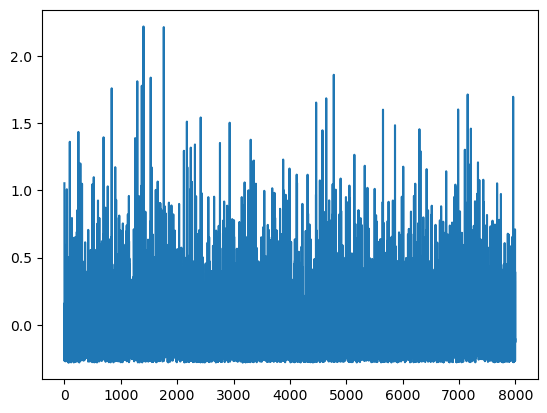

In [31]:
plt.plot(X_test_chunks_temp_flattened)

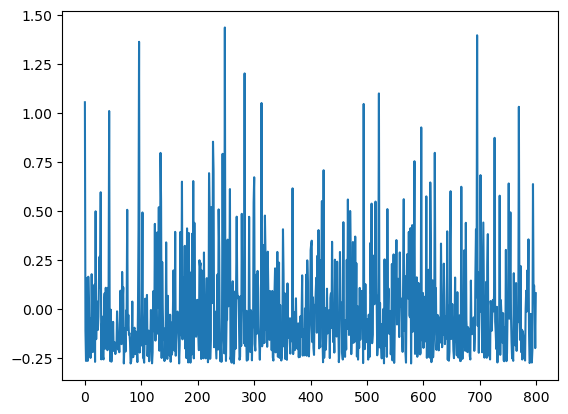

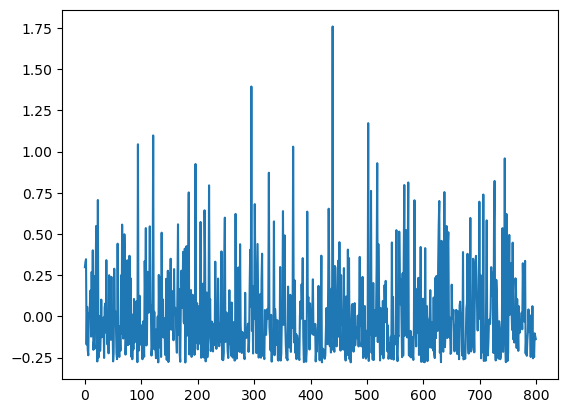

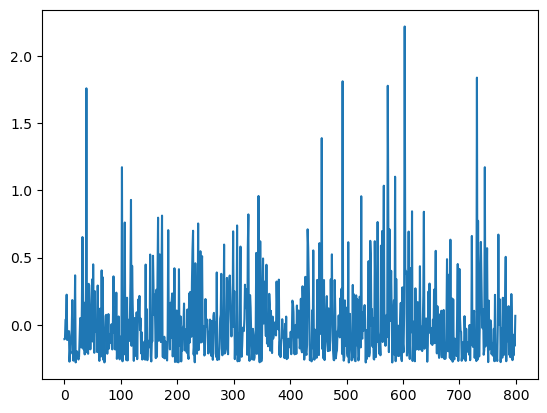

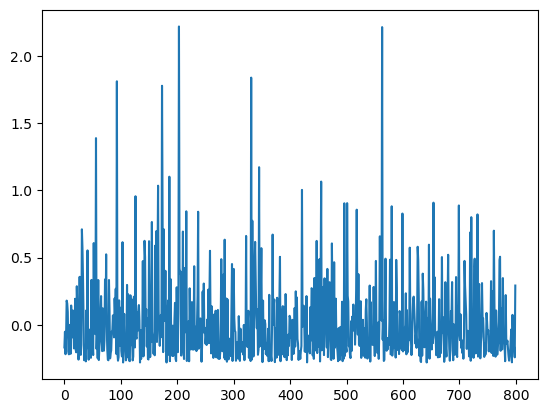

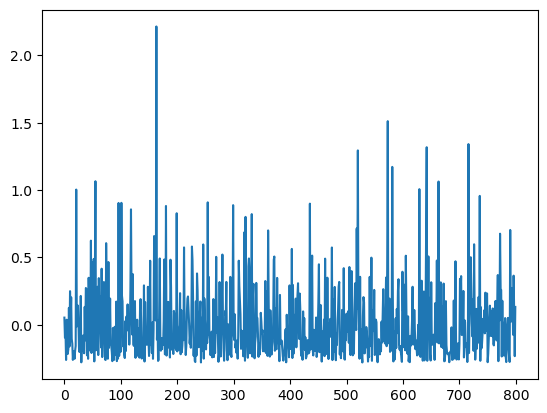

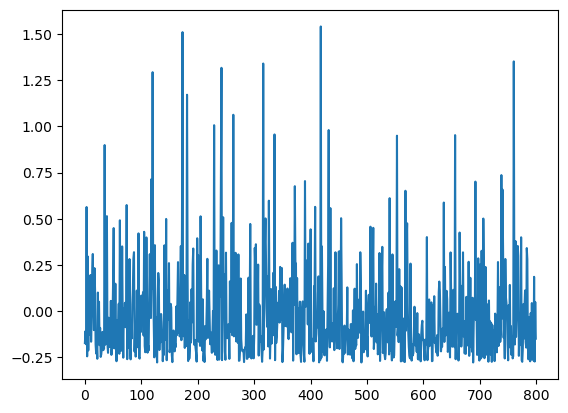

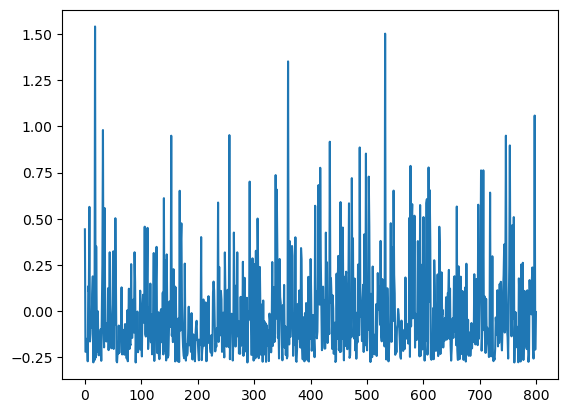

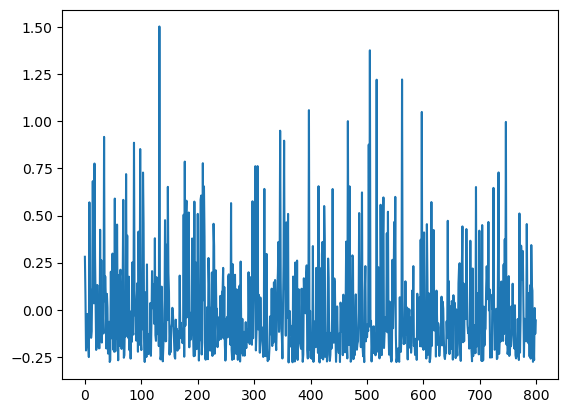

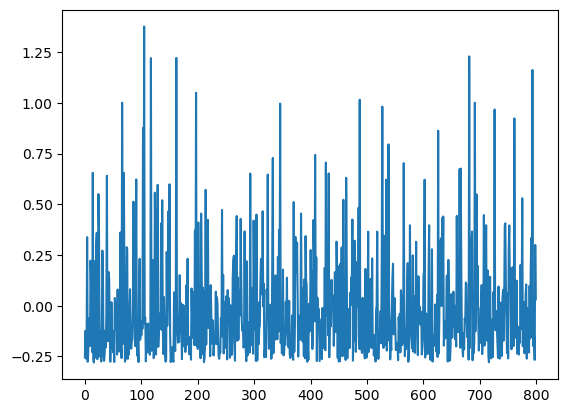

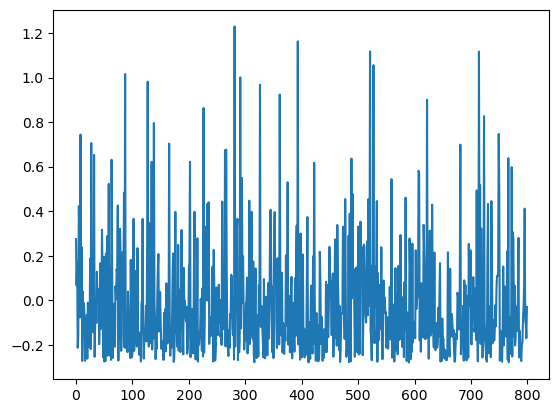

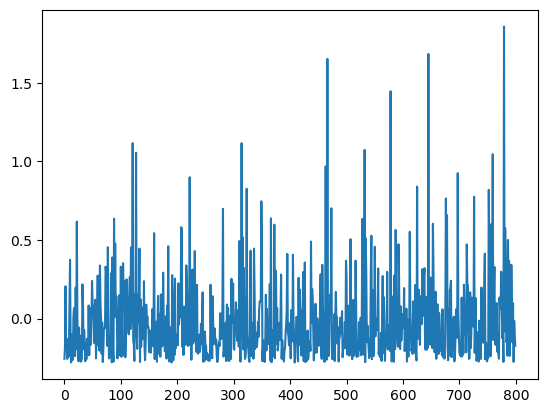

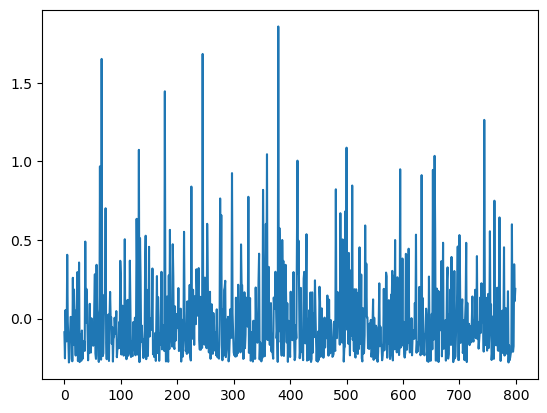

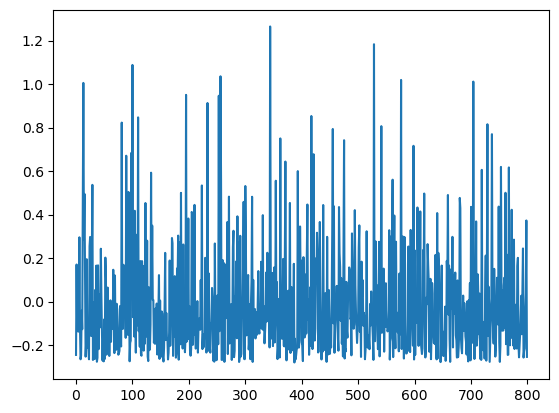

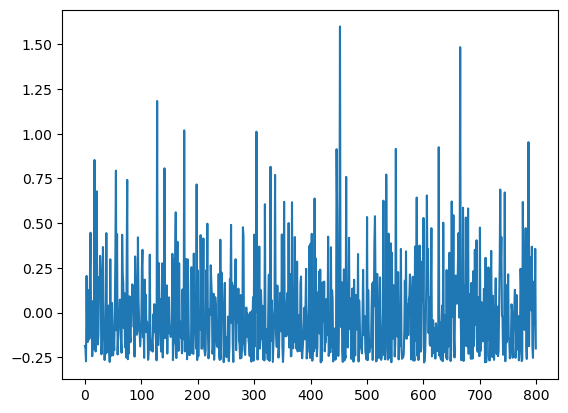

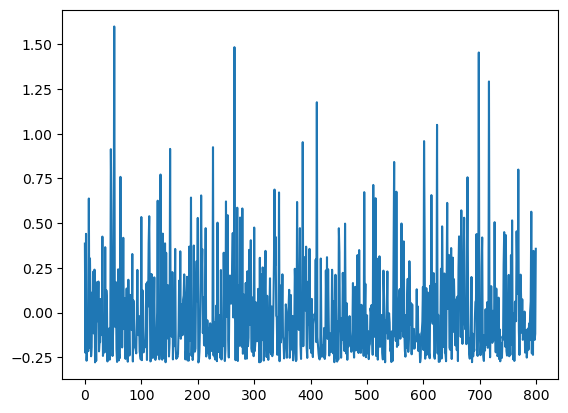

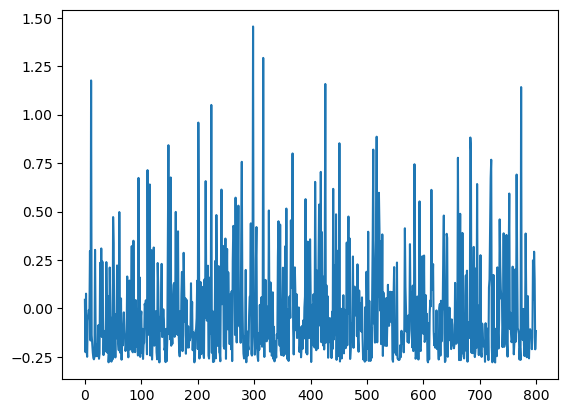

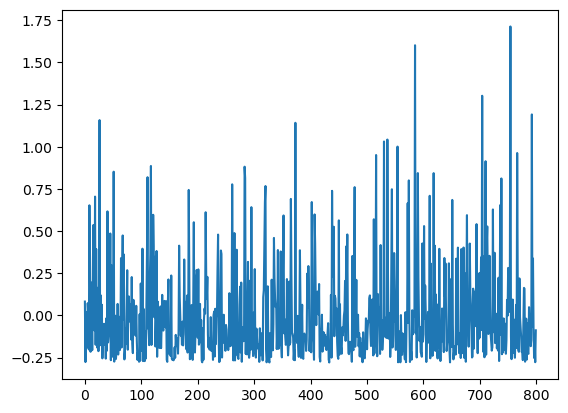

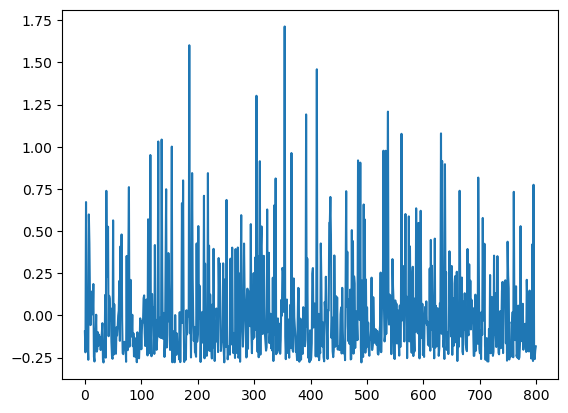

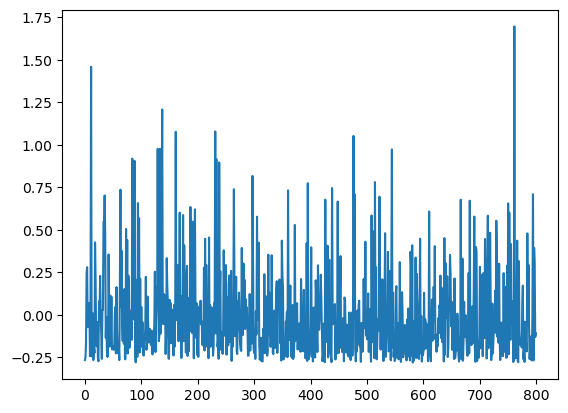

In [30]:
for i in range(X_test_chunks_temp_overlapped.shape[0]):
    plt.plot(X_test_chunks_temp_overlapped[i])
    plt.show()
    plt.close()

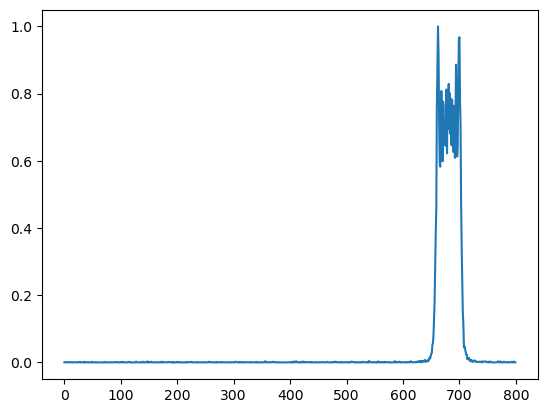

In [22]:
plt.plot(X_test_freq_chunks_norm[108])

In [225]:
p = labels_df.loc[test_indices[ind]]['p_middle']
f = 1/p
f_ind = f/freq_res

print(roll_number,f_ind,regressor_chunk_start,regressor_chunk_end)

0 59792.59289059561 59687.0 60087.0


In [226]:

final_chunk = power[int(regressor_chunk_start):int(regressor_chunk_end)]
#final_chunk = power[93410:93810]
final_chunk = final_chunk/np.max(final_chunk)
f = model_regressor_f(final_chunk.reshape((1,400,1)).astype(np.float64)).numpy()[0][0]
z = model_regressor_z(final_chunk.reshape((1,400,1)).astype(np.float64)).numpy()[0][0]

p_pred = 1000/((int(regressor_chunk_start) + f)*freq_res)
p_true = labels_df.loc[test_indices[ind]]['p_middle']*1000
print('predicted_frequency is:',f)
print('predicted_acceleration is:',z/2)
print('predicted_period [ms]: ',p_pred)
print('True period [ms]:',p_true)
print('Period_deviation:',np.abs(p_pred-p_true)/p_true*100,'%')
print('Time taken:',time.time()-time_start,'seconds')

predicted_frequency is: 105.77078
predicted_acceleration is: 16.418739318847656
predicted_period [ms]:  17.957719803725606
True period [ms]: 17.95777323061837
Period_deviation: 0.0002975140184487777 %
Time taken: 4.501571178436279 seconds


In [232]:
np.matmul(final_chunk.reshape((400,1)).astype(np.float64), numpy_weights_f)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 30 is different from 1)

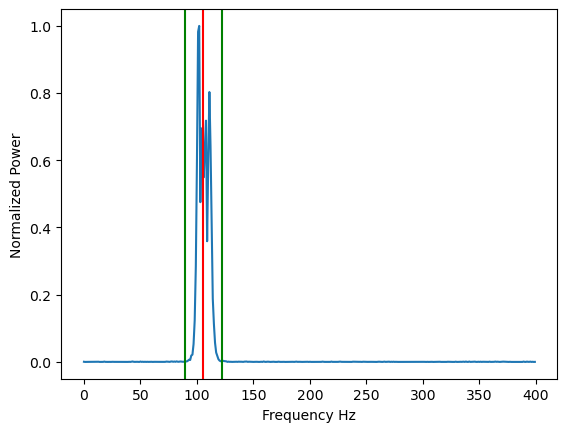

In [227]:
plt.plot(final_chunk)
plt.xlabel('Frequency Hz')
plt.ylabel('Normalized Power')
plt.axvline(f, color='r')
plt.axvline(f + z/2, color='g')
plt.axvline(f - z/2, color='g')